# Partie II - Motion Compensation

### Imports

In [76]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

### Load and display images

In [77]:
def load_image(path: str) -> np.ndarray:
    """
    Load image from path and convert it to grayscale
    
    :param path: path to image
    :return: image in grayscale
    """
    img = cv2.imread(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def display_images(imgs: np.ndarray, titles: list=None) -> None:
    """
    Display two images with matplotlib

    :param img1: first image to display
    :param img2: second image to display
    :param title1: title of the first image
    :param title2: title of the second image
    """
    num_imgs = imgs.shape[0]
    _, axs = plt.subplots(1, num_imgs, figsize=(16, 8))
    for i in range(num_imgs):
        axs[i].imshow(imgs[i], cmap='gray')
        if titles is not None:
            axs[i].set_title(titles[i])
        else:
            axs[i].set_title(f'Frame {i}')
        axs[i].axis('off')
    plt.show()

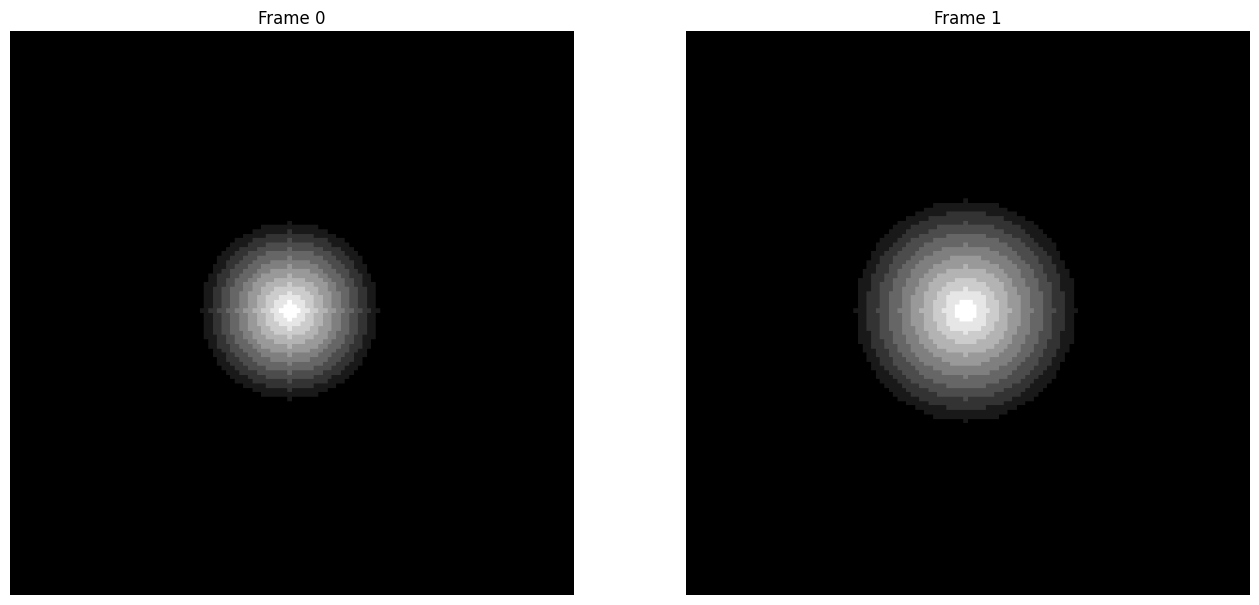

In [78]:
pic1, pic2 = load_image('./images/1.png'), load_image('./images/2.png')
display_images(np.array([pic1, pic2]))

### A - Backward estimation
Au TP1, vous avez réalisé de l’estimation de mouvement de type forward par blocs entre F1 et F2. Procédez maintenant à de l’estimation backward par blocs entre F1 et F2.</br>
<u>Note :</u> c’est désormais F2 que l’on décompose en blocs et non pas F1.

In [79]:

def compute_ideal_motion_vectors_BMA(frame1: np.ndarray, frame2: np.ndarray, block_size: int, window_size: int, current_block: np.ndarray, x: int, y: int) -> tuple[int, int]:
    """
    Compute the ideal motion vectors between two frames
    :param frame1: first frame
    :param frame2: second frame
    :param block_size: size of a block
    :param window_size: size of the window
    :param current_block: current block
    :param x: x coordinate of the current block
    :param y: y coordinate of the current block
    """
    i, j = x, y
    E = np.inf
    new_x = 0
    new_y = 0

    # Search in the window
    for k in range(i - window_size, i + window_size):
        for l in range(j - window_size, j + window_size):
            # If the pixel is outside the frame, we skip it
            if k < 0 or k >= frame2.shape[0] or l < 0 or l >= frame2.shape[1]:
                continue
            # Define a new block for the current iteration
            new_block = frame2[k:k+block_size, l:l+block_size]

            # If the new block is not the same size as the current block, we skip it
            if new_block.shape != current_block.shape:
                continue

            # If a pixel is the same in both frames, we can stop the search
            if k == i and l == j and np.array_equal(new_block, current_block):
                return None

            # Compute the error between the two blocks
            E_new = np.sum(np.abs((new_block - current_block)) ** 2)
            
            # Compute the distance between the two pixels at position (k, l) and (i, j)
            diff_x = k - i
            diff_y = l - j

            # If the new error minimizes the previous one, we update the error and the motion vectors
            if E_new < E:
                E = E_new
                new_x = diff_x
                new_y = diff_y
            # elif E_new == E and (np.abs(diff_x) + np.abs(diff_y)) < (np.abs(new_x) + np.abs(new_y)):
            #     new_x = diff_x
            #     new_y = diff_y

    return new_x, new_y

  0%|          | 0/67 [00:00<?, ?it/s]

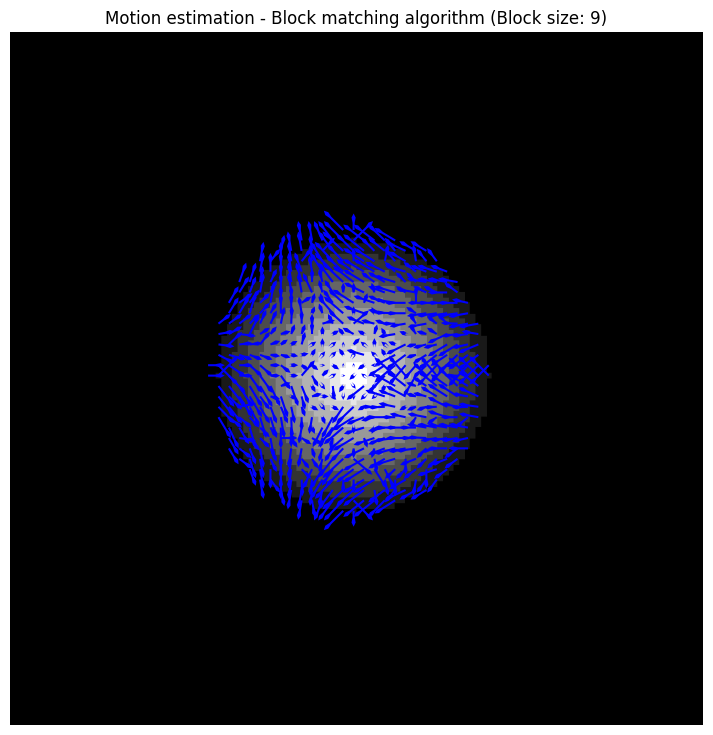

In [91]:
def BMA(frame1: np.ndarray , frame2: np.ndarray, block_size: int = 16, window_size: int = 7) -> tuple[np.ndarray]:
    """
    Compute the motion estimation between two frames using the block matching algorithm

    :param frame1: first frame
    :param frame2: second frame
    :return: motion vectors
    """
    assert frame1.shape == frame2.shape, "Frames must have the same shape"

    frame_shape = frame1.shape

    # Normalize frames
    frame1 = frame1 / 255
    frame2 = frame2 / 255
    
    # Initialize motion vectors
    v_x = []
    v_y = []

    moving_blocks_x = []
    moving_blocks_y = []

    for i in tqdm(range(0, frame_shape[0], block_size)):
        for j in range(0, frame_shape[1], block_size):
            # Get the current block
            current_block = frame1[i:i+block_size, j:j+block_size]

            # Compute the motion vectors for the current block
            motion_vectors = compute_ideal_motion_vectors_BMA(frame1, frame2, block_size, window_size, current_block, i, j)

            # Add the motion vectors to the list
            if motion_vectors != (0, 0) and motion_vectors is not None:
                v_x.append(motion_vectors[0])
                v_y.append(motion_vectors[1])
                moving_blocks_x.append(i)
                moving_blocks_y.append(j)

    return v_x, v_y, moving_blocks_x, moving_blocks_y

def BMA_display(frame1: np.ndarray, frame2: np.ndarray, block_size: int = 16, window_size: int = 10) -> tuple[np.ndarray]:
    v_x , v_y, moving_blocks_x, moving_blocks_y = BMA(frame1, frame2, block_size=block_size, window_size=window_size)
    _, ax = plt.subplots(1, 1, figsize=(9, 9))
    ax.imshow(frame1, cmap='gray')
    ax.set_axis_off()
    ax.set_title(f'Motion estimation - Block matching algorithm (Block size: {block_size})')

    ax.quiver(moving_blocks_x, moving_blocks_y, v_x, v_y, scale=1000, color='blue', headwidth=2, headlength=2, width=0.003)
    plt.show()

    return v_x, v_y, moving_blocks_x, moving_blocks_y

BLOCK_SIZE = 9
WINDOW_SIZE = 30
# Use pic2 as first frame, that will decomposed into blocks
# Use pic1 as second frame, that will be used to find the best match for each block
v_x, v_y, moving_blocks_x, moving_blocks_y = BMA_display(pic2, pic1, block_size=BLOCK_SIZE, window_size=WINDOW_SIZE)

### B - Sachant que l’on va vouloir reconstruire la frame F2 à partir de F1, pourquoi a-t-on donc fait de la ME backward et pas de la ME forward ? Que se serait-il passé sinon ? (pensez à quels artéfacts visuels on aurait obtenu)


### C - Reconstruisez l’image F2 à partir de vos vecteurs de mouvements et de F1. Quelle est la MSE de reconstruction ?

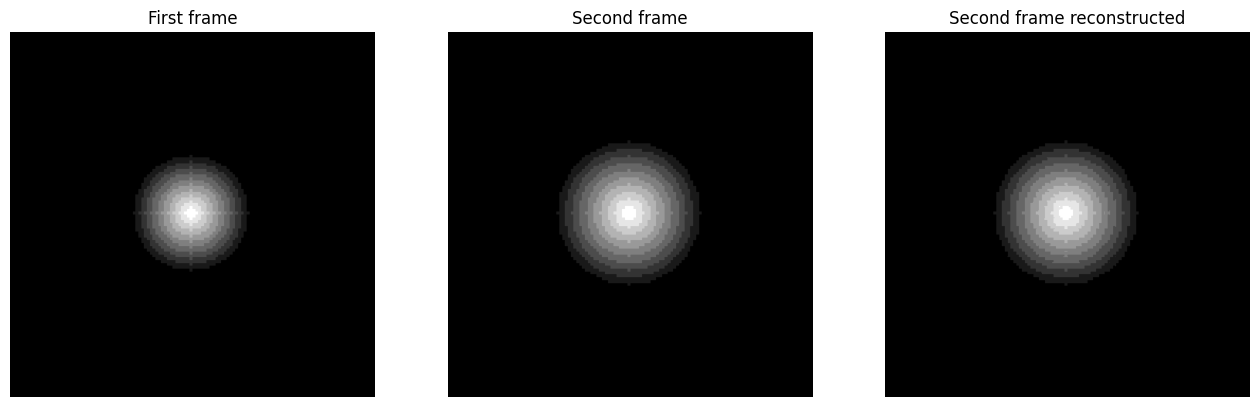

Percentage of pixels that are the same in both frames:
99.94%
Parameters: block size = 9, window size = 30


In [92]:
# Reconstruction of the second frame using the motion vectors and the first frame
pic2_reconstructed = np.zeros(pic2.shape)
for i in range(len(moving_blocks_x)):
    x = moving_blocks_x[i]
    y = moving_blocks_y[i]
    pic2_reconstructed[x:x+BLOCK_SIZE, y:y+BLOCK_SIZE] = pic1[x+v_x[i]:x+v_x[i]+BLOCK_SIZE, y+v_y[i]:y+v_y[i]+BLOCK_SIZE]
# Display the reconstructed frame

display_images(np.array([pic1, pic2, pic2_reconstructed]), titles=['First frame', 'Second frame', 'Second frame reconstructed'])

# Percentage of pixels that are the same in both frames
print(f'Percentage of pixels that are the same in both frames:\n{np.sum(np.square(pic2 - pic2_reconstructed) < 1e-3) / (pic2.shape[0] ** 2) * 100:.2f}%')
print(f'Parameters: block size = {BLOCK_SIZE}, window size = {WINDOW_SIZE}')

### D - Supposant que l’on n’aura plus accès à F2, quelles sont les 3 données ”classiques” (en plus du paramètres de taille de bloc) dont on a besoin pour la reconstruire de façon parfaite en compensation de mouvement ?

### E - Reconstruisez F2 à partir de ces 3 données. Quelle est désormais la MSE de reconstruction ?

### F - Expliquez quelles données on peut coder avec perte pour garder une qualité de reconstruction de F1 et F2 ”correcte”. Justifiez vos explications par des images de rendus.

### G - Qu’est-ce-qui aurait changé si on utilise une méthode à base de mesh du point de vue de la minimisation ? Et du point de vue du rendu final ? Montrez vos résultats en vous aidant du TP1.